# Analyze dLight signal quality

Throw out sessions or segments of time that have too high a correlation with motion artifact

In [1]:
import os
import numba
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import format_plots, save_factory, PlotConfig, figure, legend

In [2]:
numba.set_num_threads(int(os.environ.get("SLURM_JOB_CPUS_PER_NODE", 1)))

In [3]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "dlight", tight_layout=False)

In [4]:
version = 7
file = Path(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/dlight_photometry_df.parquet"
)

In [5]:
df = pd.read_parquet(file)
df = relabel_by_usage(df, return_map=False)

In [6]:
# grab individual sessions

for uuid, _df in df.groupby('uuid', sort=False):
    break

In [7]:
_df.columns

Index(['pmt00_ref00 (dLight)', 'pmt00_ref01 (UV)', 'timestamp',
       'raw_timestamp', 'fs', 'ir_indices', 'subject_name', 'session_name',
       'start_time', 'syllables', 'uuid', 'dlight_dff', 'uv_dff',
       'dlight_reref', 'uv_reference_fit', 'dlight_reref_zscore',
       'dlight_reref_zscore_filter', 'onsets', 'relabeled_syllables'],
      dtype='object')

<Axes: xlabel='timestamp'>

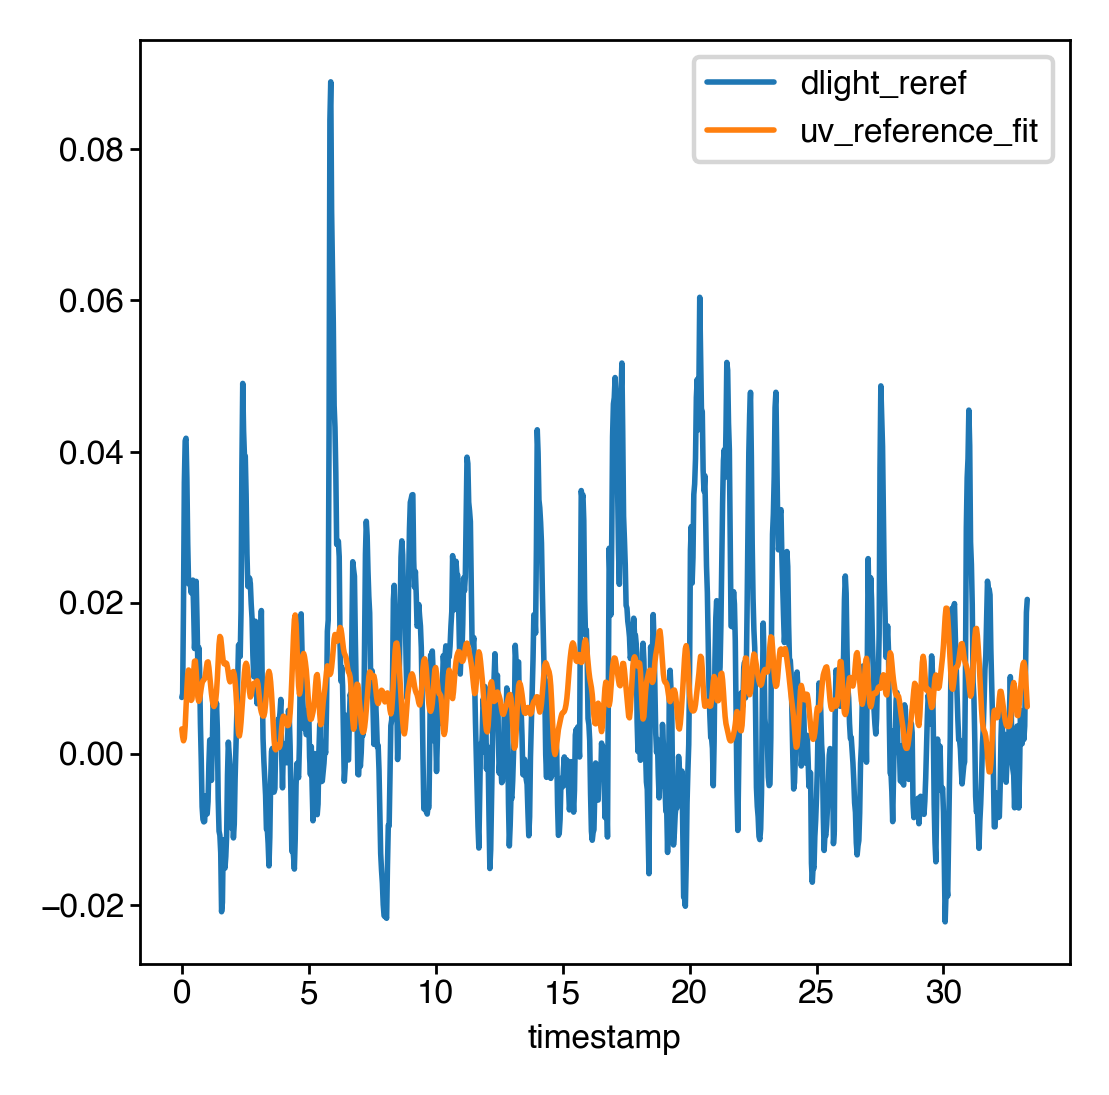

In [8]:
_df.set_index('timestamp')[['dlight_reref', 'uv_reference_fit']].iloc[:1000].plot()

In [9]:
rolling_corr_df = _df.set_index('timestamp')[['dlight_dff', 'uv_reference_fit']].rolling(30 * 15, center=True).corr()
rolling_corr_df = rolling_corr_df.loc[pd.IndexSlice[:, 'uv_reference_fit'], 'dlight_dff']
rolling_corr_df = rolling_corr_df.droplevel(1)

<Axes: xlabel='timestamp'>

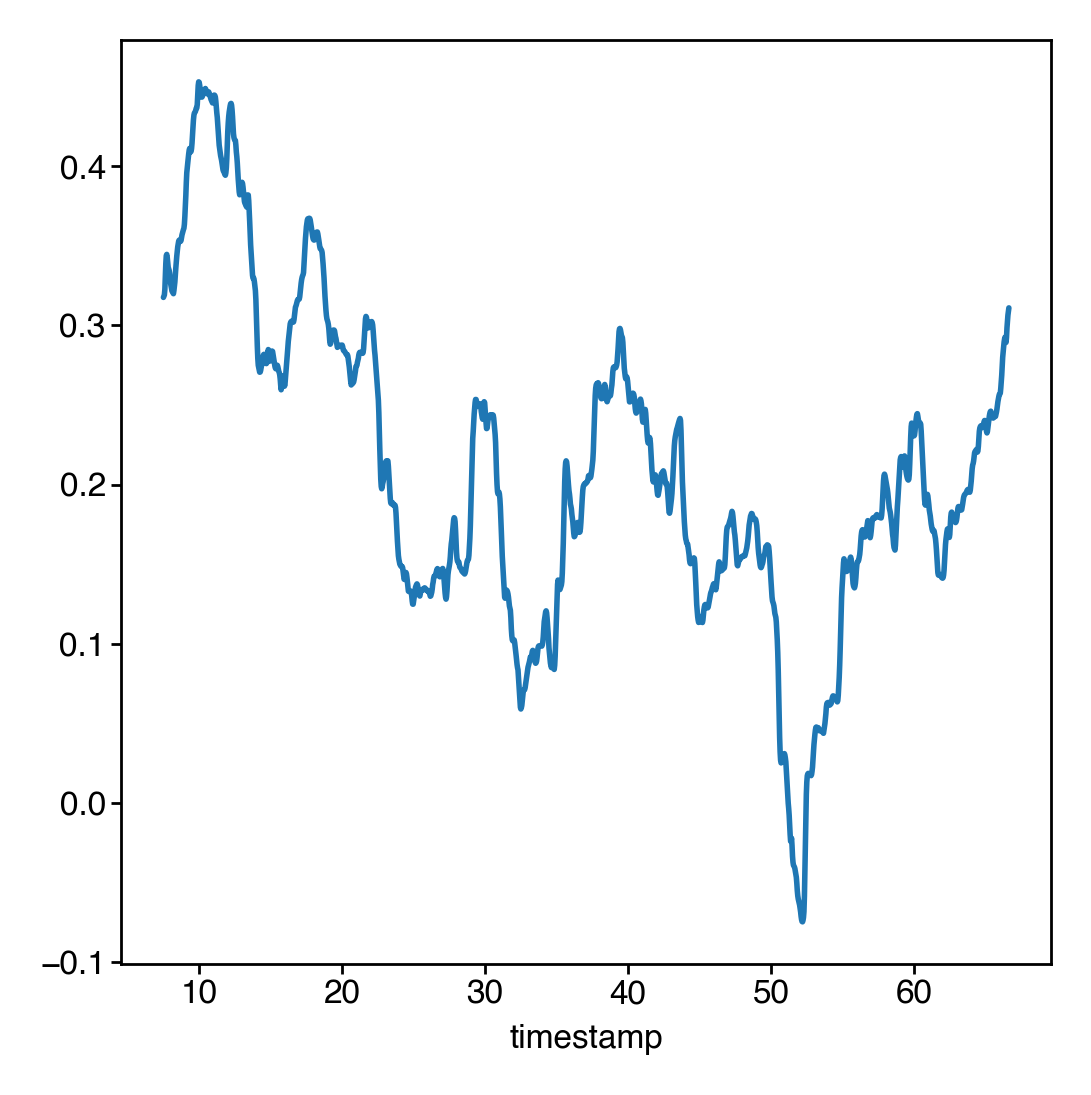

In [10]:
rolling_corr_df.iloc[:2000].plot()

## Compute correlations btw dlight dff and uv dff

In [11]:
corr_per_session = df.groupby('uuid', sort=False)[['dlight_dff', 'uv_reference_fit']].corr()
corr_per_session = corr_per_session.loc[pd.IndexSlice[:, "uv_reference_fit"], "dlight_dff"].droplevel(1)
df['session_motion_corr'] = df['uuid'].map(corr_per_session)

In [12]:
corr_per_session

uuid
e4b59581-a54e-4033-9612-86b903a59909    0.201335
36542bc2-b785-4287-8523-4acd01550cd5    0.109966
9d8d7abf-57c5-4dd3-96bb-4bb017e568cd    0.109606
9f6d7845-4a88-4dc1-9249-45c65accae27    0.171205
ce365256-7ec0-4080-93b7-a33747f28a2e    0.225338
                                          ...   
9d89ba11-4ab1-42e6-956a-ec67307a5875    0.167192
368ef888-b064-4f4d-b2b0-8bd1674a9a13    0.254939
d6083afd-a6fc-4672-abb4-5f65f38e26cf    0.210985
3a73b20f-bae0-4790-b423-e64dd247b3b2    0.193748
939c9861-bc2e-4f97-9709-9aae5f9221e5    0.170145
Name: dlight_dff, Length: 154, dtype: float64

<Axes: xlabel='dlight_dff', ylabel='Count'>

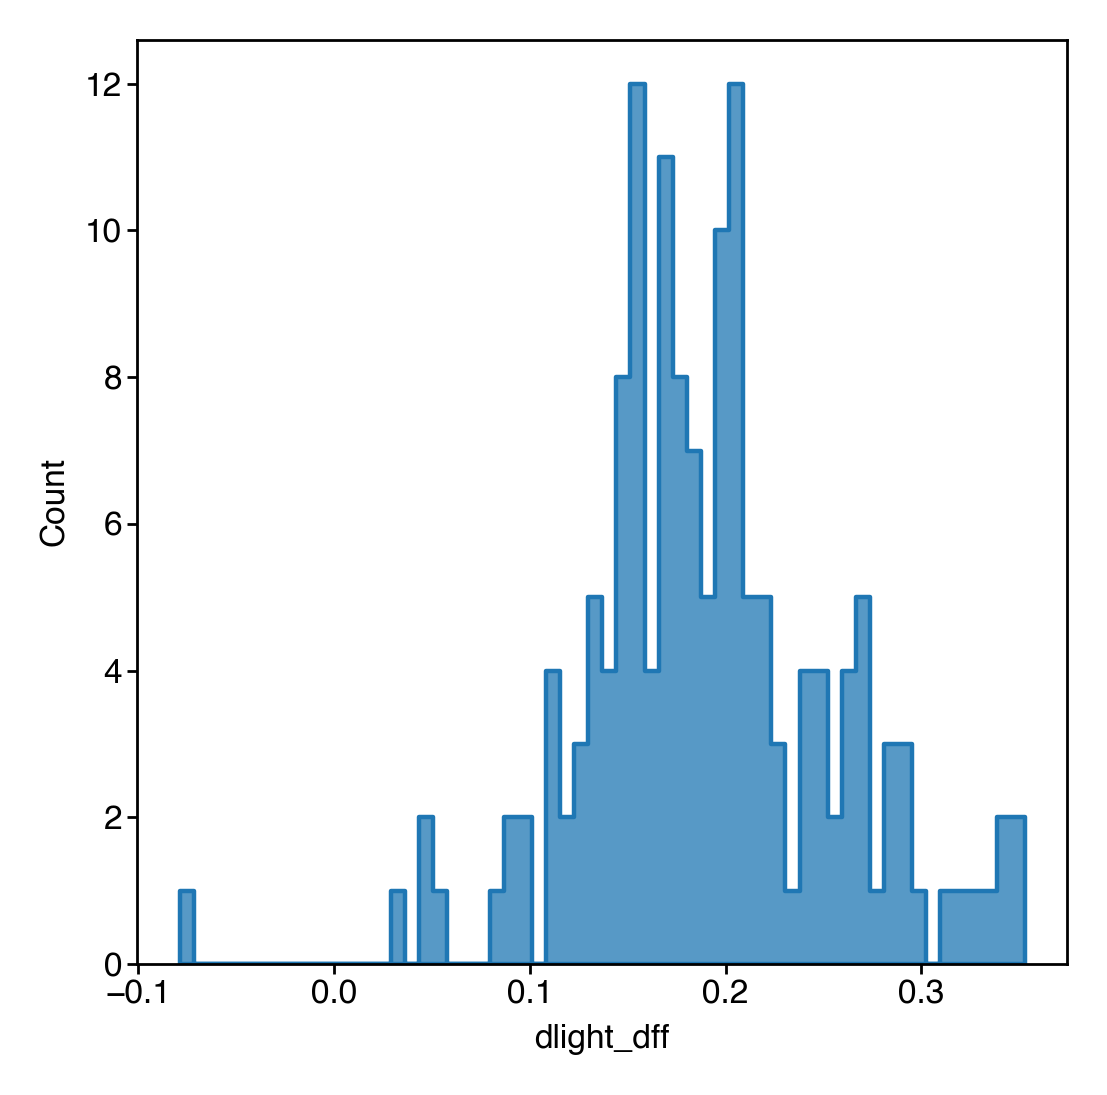

In [13]:
# thresholds to try:
# - 0.225, 0.25, 0.275, 0.3
sns.histplot(corr_per_session, element='step', bins=60)

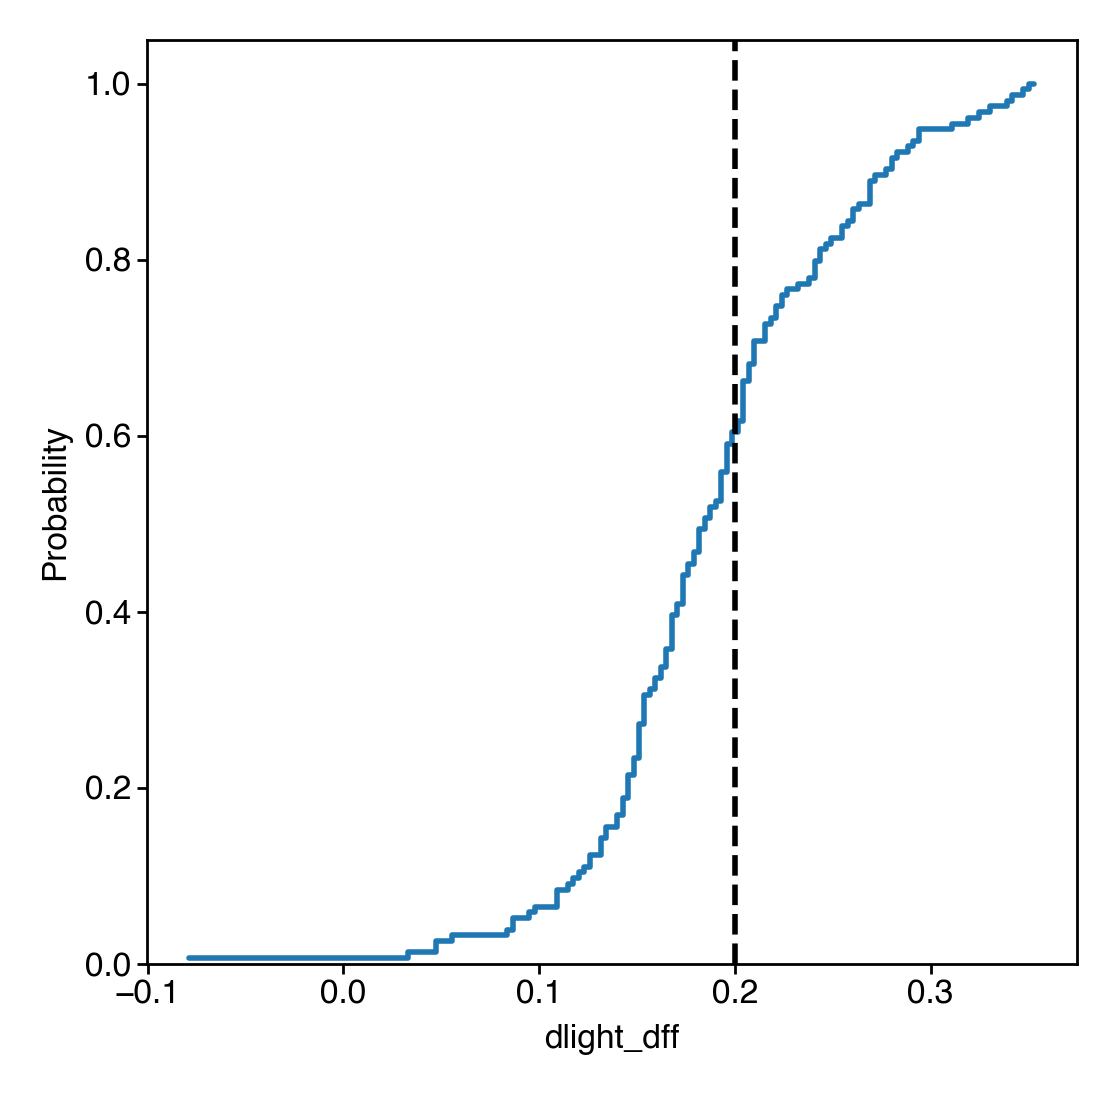

In [14]:
ax = sns.histplot(
    corr_per_session,
    element="step",
    bins=df["uuid"].nunique(),
    cumulative=True,
    stat="probability",
    fill=False
)
ax.axvline(0.2, color='k', ls='--')

## Re-do SNR

In [15]:
dlight_max = df.groupby('uuid', sort=False)['dlight_dff'].quantile(0.95)
uv_std = df.groupby('uuid', sort=False)['uv_dff'].std()
snr = dlight_max / uv_std

<Axes: ylabel='Count'>

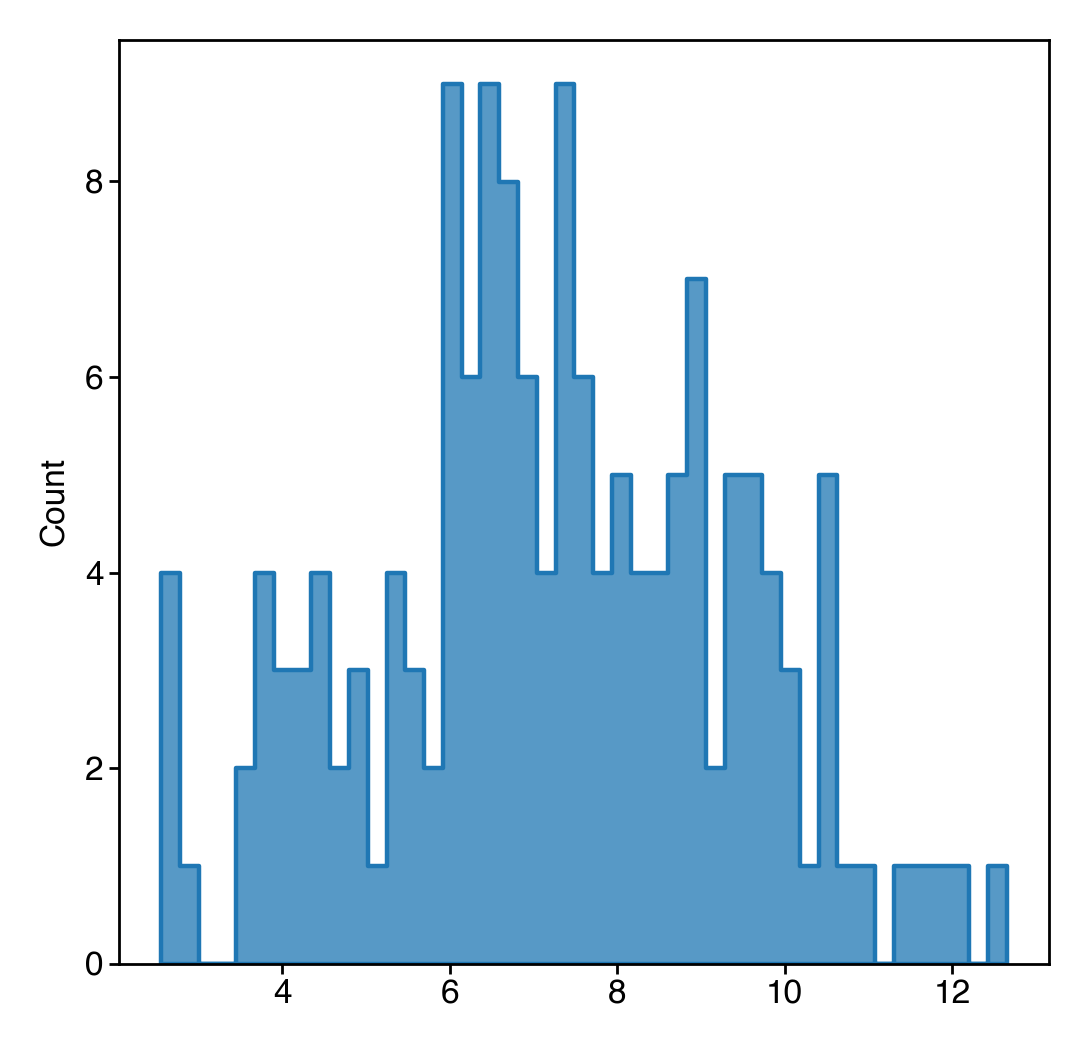

In [16]:
sns.histplot(snr, element='step', bins=45)

In [17]:
df['snr'] = df['uuid'].map(snr)

## Rolling motion artifact correlations

In [18]:
rolling_corr_df = df.groupby('uuid', sort=False)[['dlight_dff', 'uv_reference_fit']].rolling(30 * 15, center=True).corr()
# rolling_corr_df = rolling_corr_df.loc[pd.IndexSlice[:, 'uv_reference_fit'], 'dlight_dff']
# rolling_corr_df = rolling_corr_df.droplevel(1)

In [19]:
rolling_corr_df.head()

dlight_dff  \
uuid                                                                  
e4b59581-a54e-4033-9612-86b903a59909 0 dlight_dff               NaN   
                                       uv_reference_fit         NaN   
                                     1 dlight_dff               NaN   
                                       uv_reference_fit         NaN   
                                     2 dlight_dff               NaN   

                                                         uv_reference_fit  
uuid                                                                       
e4b59581-a54e-4033-9612-86b903a59909 0 dlight_dff                     NaN  
                                       uv_reference_fit               NaN  
                                     1 dlight_dff                     NaN  
                                       uv_reference_fit               NaN  
                                     2 dlight_dff                     NaN

In [20]:
df['rolling_motion_corr'] = rolling_corr_df.loc[pd.IndexSlice[:, :, 'uv_reference_fit'], 'dlight_dff'].droplevel([0, 2]).rename('rolling_motion_corr')

In [22]:
uuids = df['uuid'].unique()

In [23]:
plt_corr = rolling_corr_df.loc[pd.IndexSlice[:, :, 'uv_reference_fit'], 'dlight_dff']

[Text(0.5, 0, 'Motion artifact correlation (R)')]

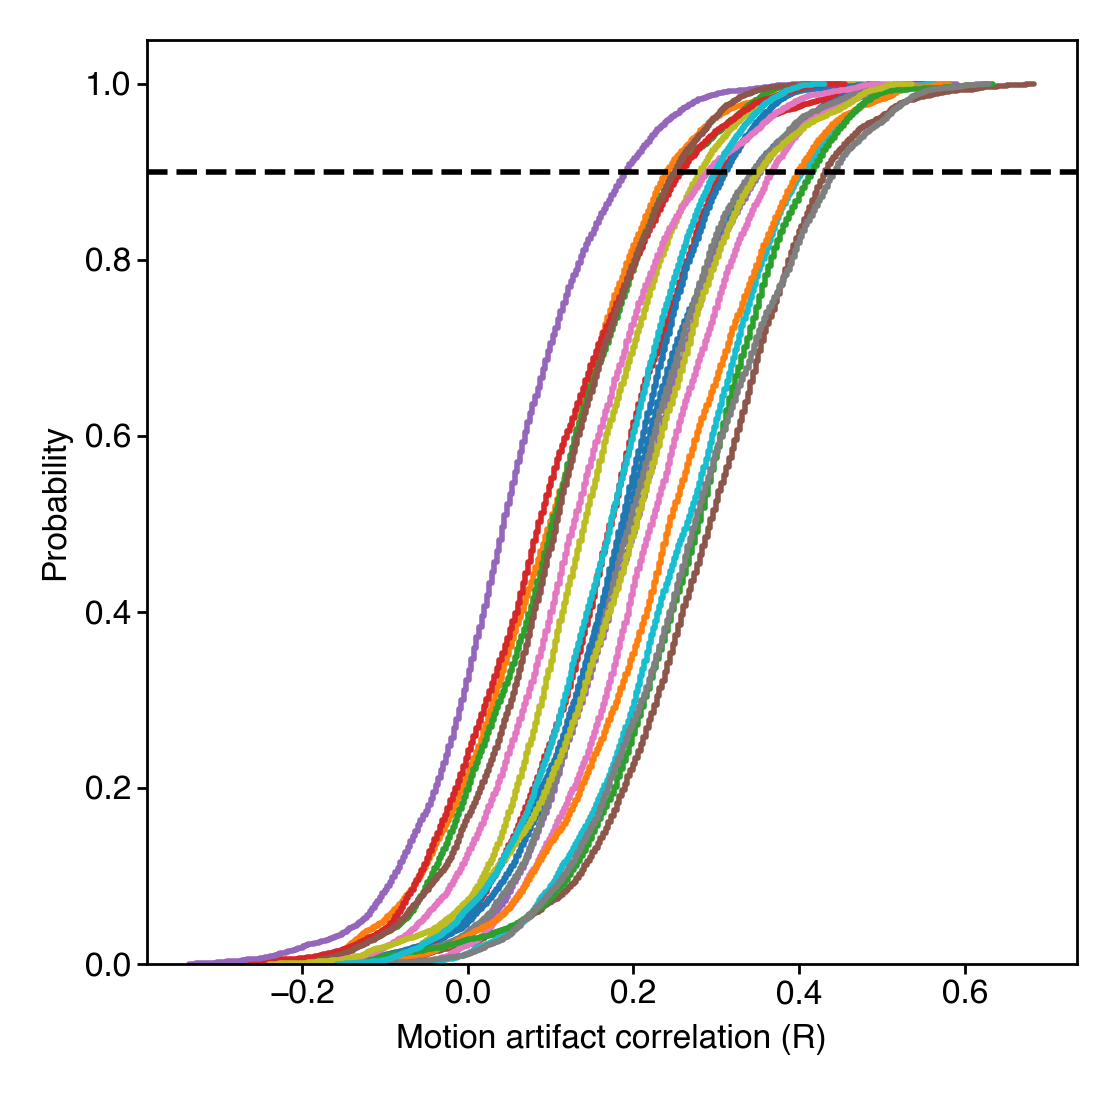

In [24]:
for i in range(20):
    ax = sns.histplot(
        plt_corr.loc[uuids[i]],
        element="step",
        cumulative=True,
        fill=False,
        stat="probability",
        bins=250
    )

ax.axhline(0.9, color='k', ls='--')
ax.set(xlabel="Motion artifact correlation (R)")

In [25]:
file

PosixPath('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/dlight_photometry_df.parquet')

In [26]:
file.with_name("dlight_photometry_df_filter_stats.parquet")

PosixPath('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/dlight_photometry_df_filter_stats.parquet')

In [27]:
df.to_parquet(
    file.with_name("dlight_photometry_df_filter_stats.parquet"), compression="brotli"
)